Klassifikation des Genres eines Songs anhand des Textes (Pascal Niedermeyer, Philipp Tull, Simon Triem)
Ziel dieses Projektes ist es, zu Prüfen, ob es möglich ist, das Genre eines Songs anhand des Textes korrekt vorherzusagen. Dabei werden unterschiedliche Modelle aus den Bereichen Machine Learning sowie Neuronale Netze verwendet.
Es wird nicht nur evaluiert ob und wie gut die verschiedenen Modelle des Genre vorhersagen, sondern auch, wie gut die Modelle im Vergleich untereinander abschneiden.
Da oftmals nicht nur ein Vergleich zwischen verschiedenen Modellen interresant ist, sondern auch der Vergleich zwischen Mensch und Maschine interresante Ergebnisse liefert, testen wir die Textklassifikation auch an verschiedenen menschlichen Probanten. Diese Ergebnisse werden am Ende des Dokumentes vorgestellt. 

Die in diesem Projekt verwendeten Daten stammen von https://www.kaggle.com/.


Im ersten Codeblock filtern wir die Rohdaten (wie in den Kommentaren beschrieben):

Bevor wir mit der Beschreibung der verschiedenen Modellen beginnen, müssen zuvor noch ein paar Anpassungen der Daten vorgenommen werden. 
Da es sich bei den zuvor erwähnten Daten von Kaggle um eine riesige Menge an Information handelt und ein Großteil dieser Information für unser Projekt irrelevant ist, müssen wir zuerst die Daten etwas berreinigen, verkleinern und anpassen.
In unseren Vorhersagemodellen arbeiten wir nur mit englischen Texten. Daher werden alle anderen Textsprachen im weiteren Verlauf nicht mehr betrachtet. Des Weiteren werden alle Wörter, die in unseren Daten groß geschrieben sind, in kleingeschirebene Wörter transformiert.
Auch befinden sich in den Lyrics teilweise keine Texte an sich sondern auch Instrumentals oder andere Zeichenfolgen, mit denen unsere Modelle nichts anfangen können. Daher werden auch diese Texte im Weiteren nicht betrachtet.
In unseren Daten gibt es sechs verschiedene Genres: (Rock, Pop, Hip Hop, Samba, Sertanejo und Funk Carioca). Allerdings sind Samba, Sertanejo und Funk Cariocanur nur sehr wenig vertreten. Deshalb fließen diese Genre nicht in unsere Bewertung mit ein, da durch die wenigen Daten kein vernüftiges Ergebnis entstehen würde.

In [27]:
import pandas as pd


pathLyrics = "./song-lyrics/lyrics-data.csv"
pathArtists = "./song-lyrics/artists-data.csv"

dataframeLyrics = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Nur englische Lyrics, Lowercase für Artists + Lyrics
dataLyricsFilterd = dataframeLyrics[dataframeLyrics['Idiom'] == 'ENGLISH']
dataLyricsFilterd = dataLyricsFilterd.apply(lambda x: x.astype(str).str.lower())
dataArtistsFilterd = dataframeArtists.apply(lambda x: x.astype(str).str.lower())

#Lösche Irrelevante Attribute der Artists
del dataArtistsFilterd['Genres']
del dataArtistsFilterd['Popularity']
del dataArtistsFilterd['Songs']


#print(first)
#print(dataLyricsFilterd)

#Unsere Datenanalyse ergab, dass es 3 irrelevante Genres mit sehr wenig Daten gibt.
#Da diese Genres nicht aussagekräfitg sind werden sie im weiterem Verlauf nicht betrachtet.
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'samba']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'sertanejo']
dataArtistsFilterd = dataArtistsFilterd[dataArtistsFilterd['Genre'] != 'funk carioca']

#Doppelte Artists ignorieren -> erster Artist wird jeweils genommen
sorted = dataArtistsFilterd.sort_values(['Link'])

dataArtistsFilterd = sorted.groupby('Link').first().reset_index()

i = dataArtistsFilterd

#Kleinere Datenmenge!! Zum Debuggen. Um das zu aktivieren Zeile 53 auskommentieren!
test = i[i['Artist'] == '10000 maniacs' ]
#print(test)
test2 = i[i['Artist'] == 'will.i.am' ]
test3 = i[i['Artist'] == 'jennifer lopez' ]

test = test.append(test2)
test = test.append(test3)
#In den Lyrics befinden sich einige "schmutzigen" Lyrics, bspw. Instrumentals oder Chord-Sheets. 
# Da diese irrelevant sind und unser Ergebnis negativ beeinflussen würden betrachten wir diese ebenfalls nicht.
# => Die Chordsheets haben Pattern wie "---" oder "===", Instrumentale Songs "instrumental"
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataLyricsFilterd['Lyric'].str.contains(patt)
    dataLyricsFilterd = dataLyricsFilterd[~filter]
    
#dataArtistsFilterd = test
#dataLyricsFilterd.to_csv('filterdData.csv')

Unsere zur Verfügung gestellen Daten zu Genre und Texten befinden sich in zwei Tabellen. Eine Song-Tabelle und eine Artists-Tabelle. In der Artists-Tabelle befinden sich unteranderem der Artist, der Songname, sowie das dazugehörige Genre. In der Song-Tablle befindet sich der Text und ein Verweis auf den entsprechenden Song aus der Artist-Tabelle.
Um nun mit diesen Daten arbeiten zu können, fusionieren wir die beiden Tabllen zu einer einzzelnen Tabelle. 
Informationen die im Weiteren Verlauf des Projektes nicht benötigt werden, werden auch hier entfernt, um die Datenmenge möglichst klein zu halten.
Ein Ausschnitt der beiden Tabellen und der fusionierten Tabelle befindet sich unterhalb dieses Codeblocks.  

In [28]:
#print(dataArtistsFilterd)
#Die beiden Tabellen der Artists und Lyrics werden im folgenden Zusammengeführt:
mergedData = pd.merge(dataLyricsFilterd, dataArtistsFilterd, how='inner', left_on='ALink',right_on='Link')
#print(mergedData)

#Unnötige irrelevante Attribute werden wieder entfernt:
del mergedData['ALink']
del mergedData['SName']
del mergedData['SLink']
del mergedData['Idiom']
del mergedData['Artist']
del mergedData['Link']
#mergedData
#mergedData.to_csv('mergedData.csv')

In diesem Teil sehen wir die graphische Verteilung unserer Daten anhand ihrer Genre.

<AxesSubplot:>

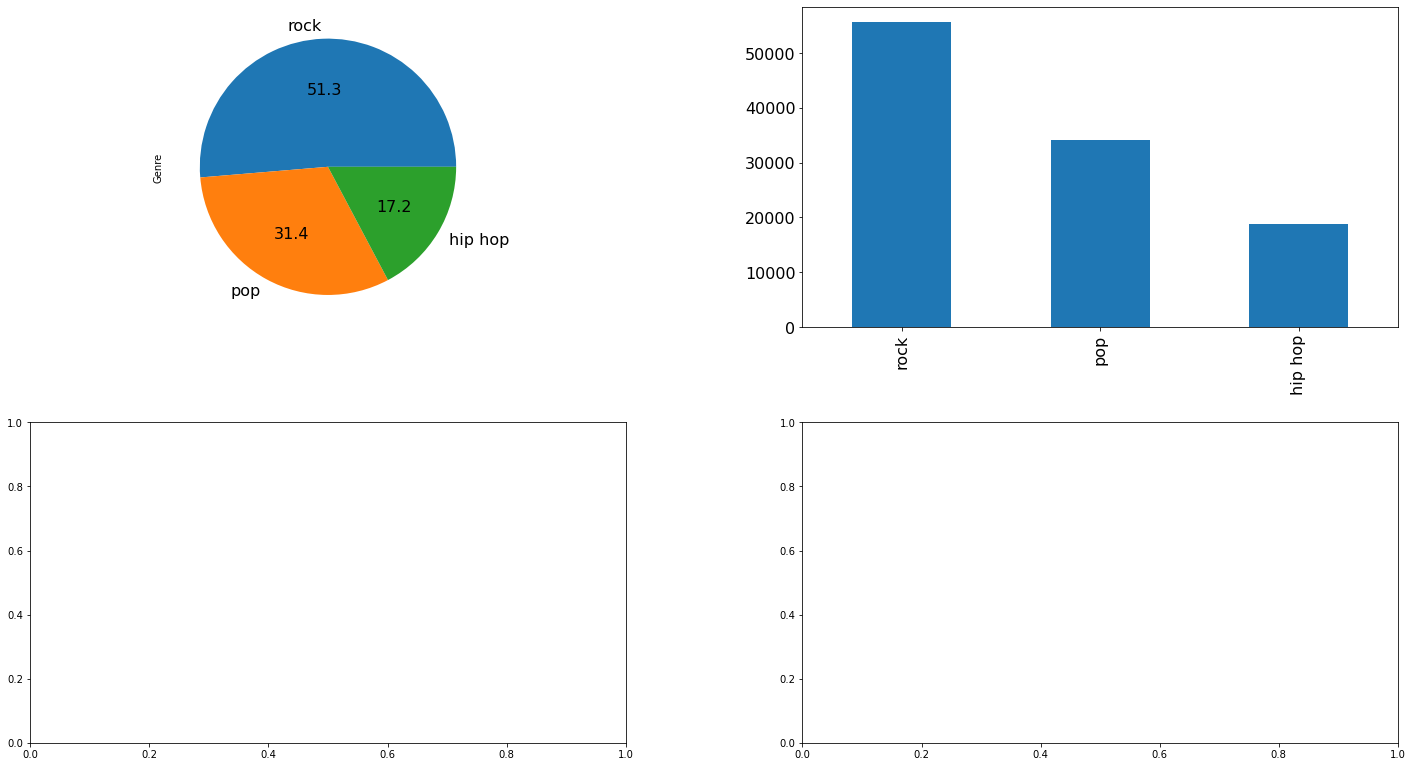

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt


genreCount = mergedData['Genre'].value_counts()

fig, axarr = plt.subplots(2, 2)
fig.tight_layout()


genreCount.plot.pie( figsize=(12, 12), fontsize=16, ax=axarr[0][0] , autopct='%.1f' )
genreCount.plot.bar( figsize=(22, 12), fontsize=16, ax=axarr[0][1] )



Anhand dieser Datenanalyse mit den gefilterten Daten sehen wir, dass die Genres einen unterschiedlichen Anteil der Datenmenge beinhalten. Das Gere mit den meisten Datensätzen umfasst über 50% der gesamten Datenmenge. Ob diese Ungelichverteilung unserem System nun einen Vorteil, bei der Vorhersage mit sich bringt, oder ob es dadurch zu einer schlechteren genauigkeit kommt, können wir nur errahnen. Wir gehen davon aus, dass es dadurch zu einer schlechteren Genauigkeit kommen wird, da unser System zwar besser auf Rock-Texte trainiert ist, allerdings bei anderen Genre Schwierigkeiten bekommen kann.

Im Folgenden werden Stoppwörter sowie irrelevante Zeichen aus den Lyrics durch Leerzeichen ersetzt. Des Weiteren möchten wir für unserer Vorhersage nur bestimmte Wörter verwenden. Hierzu betrachten wir nur die 10000 häufigsten Wörter, bzw die 10100 häufigsten wörter ohne die 100 häufigsten Wörter. Der Grund hierfür liegt darin, dass Wörter die nicht unter den 10100 häufigsten Wörten sind, so selten vorkommen das sie in unserer Vorhersage kaum bis keinen Einfluss haben, da sie zu selten vorhanden sind. Aber auch die 100 häufigsten wörter werden außen vor gelassen, weil diese Wörter praktisch fast in jedem Songtext vorhanden sind und somit auch kaum bis keine Auswirkungen auf unsere Vorhersage hätten. Anders gesagt wir würden Daten betrachten die für unser Ergebnis sogut wie irrelevant wären.

In [30]:
from collections import Counter 

#Irrelevante Zeichen und Stoppwörter
replacement = {',','.','(',')','[chorus:]','-','/','?','!','[','&',']','"'}

for index, lyric in enumerate(mergedData["Lyric"]):
    for repl in replacement:
        #Ersetze Wörter durch Leerzeichen:
        mergedData["Lyric"][index] = mergedData["Lyric"][index].replace(repl, ' ')

#Word Index mit den meisten 10.100:
word_index = Counter(" ".join(mergedData["Lyric"]).split()).most_common(10100)
#Lösche 100 häufigste Wörter raus
word_index = word_index[100:]
#print(word_index)

Die oben errechnete Häufigkeitsanalyse wird im Folgenden auf die bereits gefilteren Lyric-Daten angewendet. Hierzu betrachten wir nur relevanten Wörter pro Songtext und zählen diese.
Die Daten werden dann entsprechend in boolean-Arrays "konvertiert", damit wir ein Modell darauf trainieren können.
Die drei betrachteten Genre werden One-Hot-Encoded (Rock: 100, Pop: 010, Hip-Hop: 001):

In [31]:
#most_common = set([t[0] for t in word_index]) 
most_common = []
for t in word_index:
    most_common.append(t[0])
    
#print(len(most_common))    
#print(most_common)
xdata = []
xdata_boolean = []
ydata = []
ydata_integer = []
xdata_count = []
for lyric in mergedData['Lyric']:
    lyric_words_count = []
    cleared_lyrics_boolean = []
    for words in most_common:
        count = lyric.count(" "+words+" ")
        lyric_words_count.append(count)
        if count != 0:
            cleared_lyrics_boolean.append(1)
        else:
            cleared_lyrics_boolean.append(0)
    xdata_count.append(lyric_words_count)
    xdata_boolean.append(cleared_lyrics_boolean)
#print(xdata_count[0])    

#One Hot Encoding für das Genre:
for genre in mergedData['Genre']:
    if genre == "rock": 
        ydata_integer.append([1,0,0]);
        ydata.append(0);
    
    elif genre == "pop": 
        ydata_integer.append([0,1,0]);
        ydata.append(1);
     
    elif genre == "hip hop": 
        ydata_integer.append([0,0,1]);
        ydata.append(2);

#print (ydata_integer)

    #ydata.append(genre)
    

Nachdem die Daten gefiltert und entsprechend encoded wurden, können wir mit unseren eigentlichen Modellen zur Vorhersage der Genre anhand von Songtexten beginnen.
Für die Klassifikation anahnd eines Neuronalen Netzes verwenden wir das Feed-Forward Modell.
Hierzu werden unsere Daten in Trainigs-/ und Testdaten aufgeteilt. (0.8, 0.2) Um unser Ergebnis zu evaluieren nutzen wir 20% der Trainingsdaten als Validationsdaten.
Das Ergebnis wird unterhalb des Codeblocks dargestellt.

In [32]:
import numpy as np
from keras import models
from keras import layers
import keras as keras

from sklearn.model_selection import train_test_split
train_data, test_data, train_labels, test_labels = train_test_split(xdata_count,ydata_integer, test_size=0.2)

#print(test_data)

X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)
#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#print(X_train)

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='sigmoid'))
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
#print(model.get_weights())
history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_split=0.2)

# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               1280128   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 99        
Total params: 1,290,563
Trainable params: 1,290,563
Non-trainable params: 0
_________________________________________________________________
Train on 69457 samples, validate on 17365 samples
Epoch 1/100
69457/69457 [==============================] - 23s 329us/step - loss: 0.5874 - accuracy: 0.7137 - val_loss: 0.5260 - val_accuracy: 0.7480
Epoch 2/100
69457/69457 [=================

69457/69457 [==============================] - 21s 306us/step - loss: 0.0395 - accuracy: 0.9900 - val_loss: 0.6885 - val_accuracy: 0.8517
Epoch 49/100
69457/69457 [==============================] - 21s 305us/step - loss: 0.0401 - accuracy: 0.9898 - val_loss: 0.6972 - val_accuracy: 0.8536
Epoch 50/100
69457/69457 [==============================] - 21s 308us/step - loss: 0.0378 - accuracy: 0.9905 - val_loss: 0.7113 - val_accuracy: 0.8529
Epoch 51/100
69457/69457 [==============================] - 21s 305us/step - loss: 0.0371 - accuracy: 0.9904 - val_loss: 0.7175 - val_accuracy: 0.8553
Epoch 52/100
69457/69457 [==============================] - 21s 305us/step - loss: 0.0377 - accuracy: 0.9905 - val_loss: 0.7055 - val_accuracy: 0.8531
Epoch 53/100
69457/69457 [==============================] - 21s 307us/step - loss: 0.0356 - accuracy: 0.9910 - val_loss: 0.7107 - val_accuracy: 0.8539
Epoch 54/100
69457/69457 [==============================] - 21s 308us/step - loss: 0.0335 - accuracy: 0.991

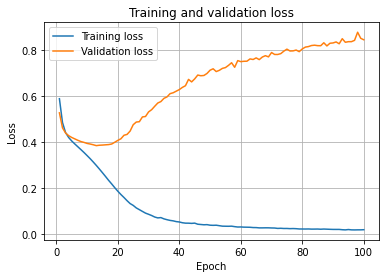

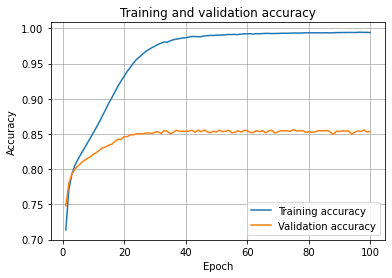

In [33]:
#Analyse deAccuracy/Loss:

history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

Trotz der ungleichen Verteilung der Genre erhalten wir einen sehr hohen Accuracy Wert für unser Vorhersagemodell. Man kann gut erkennen, wie sich die accuracy Werte schon nach wenigen Epochen auf einem konstanten Wert einpendeln, wodurch schon wenige Epochen reichen würden, um unsere Modell zu trainieren.
Als Verbesserungsmöglichkeiten für ein noch besseres Modellergebnis könnte man versuchen mit Hilfe von Word-embedding nicht nur die anhand von einzelnen Wörtern das Genre vorherzusagen, sondern anhand von mehreren aufeinander folgenden Wörtern bis ganzen Sätzen. 
Eine weitere Möglichkeit zur Verbesserung wäre die Hinzunahme von der Akustik des entsprechenden Songs. 

Um unser Neuronales Netz vergleichen zu können, nutzen wir im Folgenden eine herkömmlichen Naive-Bayse Klassifikation aus dem Bereich des Machine Learning. Dieser Arbeitet auch mit 80% Trainigs-/ und 20% Testdaten. Dadurch wollen wir evaluiren, ob bzw. in wie weit ein neutonales Netz besser ist, als ein herkömmliches Klassifikationsmodell. Denn falls dies nicht der Fall sein sollte, würde die Frage auftreten, wieso ein neuronales Netz wenn man anderweilig ein genauso guten bis besseres Ergebnis bekommen kann? 

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

train_data, test_data, train_labels, test_labels = train_test_split(xdata_boolean,ydata, test_size=0.2)


X_train = np.asarray(train_data).astype('float32')
X_test = np.asarray(test_data).astype('float32')

#print(test_labels)

#print(X_train)
#print(train_data)

y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')






## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)

## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

Kofusionsmatrix:
 [[9199 1589  322]
 [2944 3104  746]
 [ 285  918 2599]]
Korrektklassifizierungsrate:
 0.6865382843453423
Präzision (mikro):
 0.6865382843453423
Ausbeute (mikro):
 0.6865382843453423
F1 (mikro):
 0.6865382843453423


Die Accuracy unseres Naive-Bayes Modells beträgt knapp 70%.  Damit ist es ca. 15% ungenauer als unser neuronales Netz (85%).

Da unser System, wie das Gehirn des Menschen, anhand von Songtexten das entsprechende Genre vorhersagen soll, wollen wir natürlich schauen wie gut unser System im vergleich zum Menschen abschneidet. 
Dafür haben wir eine weitere Evaluation durchgeführt. Diesmal allerdings nicht mittels eines System sondern anhand von echten Menschen.
https://forms.gle/cxLjPUwuNVEAFD7z9 
Diese mussten wie unser System, anhand von Songtexten das Genre vorhersagen. Allerdings hatten die Testprobanten keinerlei Trainigsdaten sondern haben dirket mit den Validationsdaten gearbeitet. Alles gezeigten Texte der Befragung stammen aus dem Datensatz die auch für unsere Modelle vermendet wurden.
Unsere Probanten mussten also die Songtexte den drei Genren Rock, Hip und Pop zuordnen.
Hierfür haben wir 4 Songtexte pro Genre zufällig aus dem Datensatz gewählt und unsere Testpersonen entscheiden lassen,
zu welchem Genre sie den zufällig gegebenen Songtext am ehesten zuordnen würden. Wir haben bewusst einige Texte gewählt, die als Mensch relativ offensichtlich zuzuordnen sind, aber auch "schwierigere" Texte, die nicht allzu bekannt sind. Dazu haben wir uns entschieden, um den menschlichen Teilnehmern einen bewussten Vorteil zu erschaffen, den die KI unter Umständen ja auch hat (Es gibt beispielsweise schließlich bestimmte "Trigger-Wörter" wie "westside", die fast ausschließlich in Hip-Hop vorkommen würden). Der entscheidende Vorteil gegenüber der KI ist jedoch, dass bestimmte Texte unter Umständen bekannt sind, d.h eine Zuordnung zu einem bekannten Interpret erfolgt. Diese Assoziation kann unsere KI nicht herstellen. Insgesamt haben 27 Personen bei unserer Umfrage teilgenommen. Die Umfrage werten wir im Folgenden aus:


In [35]:
print("Konfusionsmatrix der Umfrage:\n")
datarray = [["        ","Rock", "Pop", "Hip-Hop"],
            ["Rock    ","71","  26","   11   "],
            ["Pop     ","25","  76","   7    "],
            ["Hip-Hop ","6 ","  5 ","   97   "]]
print(datarray[0])
print(datarray[1])
print(datarray[2])
print(datarray[3])

Konfusionsmatrix der Umfrage:

['        ', 'Rock', 'Pop', 'Hip-Hop']
['Rock    ', '71', '  26', '   11   ']
['Pop     ', '25', '  76', '   7    ']
['Hip-Hop ', '6 ', '  5 ', '   97   ']


  
4 Rock Songs
davon richtig vorhergesagt: 13/27, 19/27, 17/27, 22/27  
→ 71/108 → Accuracy von **0,66** für Rock  
4 Pop Songs  
davon richtig vorhergesagt: 24/27, 22/27, 12/27, 18/27  
→ 76/108 → Accuracy von **0,70** für Pop  
4 Hip-Hop Songs  
davon richtig vorhergesagt: 26/27, 19/27, 27/27, 25/27  
→ 97/108 → Accuracy von **0,89** für Hip-Hop  

Gesamt für 12 Songs:  
244/324 → Accuracy von **0,75**  

Man kann an den Ergebnissen gut erkennen, dass es den meisten Probanten leicht gefallen ist, das Genre Hip Hop richtig zu klassifzieren. Auch wurde Hip Hop sehr selten anderen Genre zugeordnet. Dies liegt daran das gerade Hip Hop Texte oft sehr pregnante Texte oder Wörter/Wortkombinationen enthalten die in anderen genre eher selten vorkommen. Auch beinhalten Hip Hop texte oftmals ein komplizierteres Vokabular, sowie längere Reimketten. Dies ist natürlich von dem jeweiligen Interpteter abhängig. 
Die beiden Genre Rock und Pop wurden demhingegen öffters Falsch klassifiziert. Vorallem wurde Rock häufig als Pop und Pop häufig als Rock klassifiziert. Dies lässt darauf schließen, dass sich die Texte der beiden Genre inhaltlich offtmals sehr ähneln.
Damit sind reale Personen im Vergleich zu unserem machinellen Ansatz mit einem score von 0,85 etwas schlechter.

Fazit:

Zum einen hat unser Projekt gezeigt, wie gut schon einfache Modelle und neuronale Netze Dinge zuordnen/vorhersagen können, d.h. dass sie der menschlichen Entscheidungsfindung sehr ähnlich werden können. In unserem Fallbeispiel hat unser System sogar in der Gesamtbetrachtung sogar besser abgeschnitten als unsere menschlichen Probanten. Allerdings muss dazu gesagt sein, dass unsere Testpersonen keine Daten zum trainieren hatten und auch im Vergleich zu unserem System nur zwölf Texte als Grundlage hatten. Mit mehreren Texten wäre das Ergebniss eventuell genauer geworden. Allerdings hätte dies auch mehr Zeit für die Probanten in Anspruch genommen, worunter eventuell die Konzentration gelitten hätte.
Auch konnte man gut erkennen, dass herkömmliche Klassifikationsmoddel wie Naive Bayes zwar gute Ergebnisse liefern, allerings neuranale Netze wesentlich genauer sind.

Als weitere Schritte, um unser System besser vergleichen zu können, könnte man noch die Songtexte aus der Umfrage seperat von unserem Modell klassifizieren lassen, um zu sehen, wie gut es wirklich im Vergleich mit dem Menschen entscheidet. 